🔥 Initiating God Mode Pipeline...
📦 Loading Data...
🛠️ Constructing Advanced Features...
🚀 Total Features: 58
   Ready for battle.

⚔️  FOLD 1/5 STARTED
0:	learn: 0.5839891	test: 0.5841268	best: 0.5841268 (0)	total: 1.31s	remaining: 21m 53s
100:	learn: 0.7484197	test: 0.7451280	best: 0.7452694 (95)	total: 2m 34s	remaining: 22m 58s
200:	learn: 0.7646147	test: 0.7562791	best: 0.7567219 (198)	total: 5m 8s	remaining: 20m 26s
300:	learn: 0.7723404	test: 0.7573660	best: 0.7583250 (288)	total: 7m 39s	remaining: 17m 47s
400:	learn: 0.7788369	test: 0.7582779	best: 0.7592787 (388)	total: 10m 15s	remaining: 15m 20s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7592786987
bestIteration = 388

Shrink model to first 389 iterations.
✅ Fold 1 F1-Macro: 0.7517

⚔️  FOLD 2/5 STARTED
0:	learn: 0.5839698	test: 0.5822078	best: 0.5822078 (0)	total: 1.28s	remaining: 21m 17s
100:	learn: 0.7477471	test: 0.7403830	best: 0.7403830 (100)	total: 2m 35s	remaining: 22m 59s
200:	learn: 0.7652713

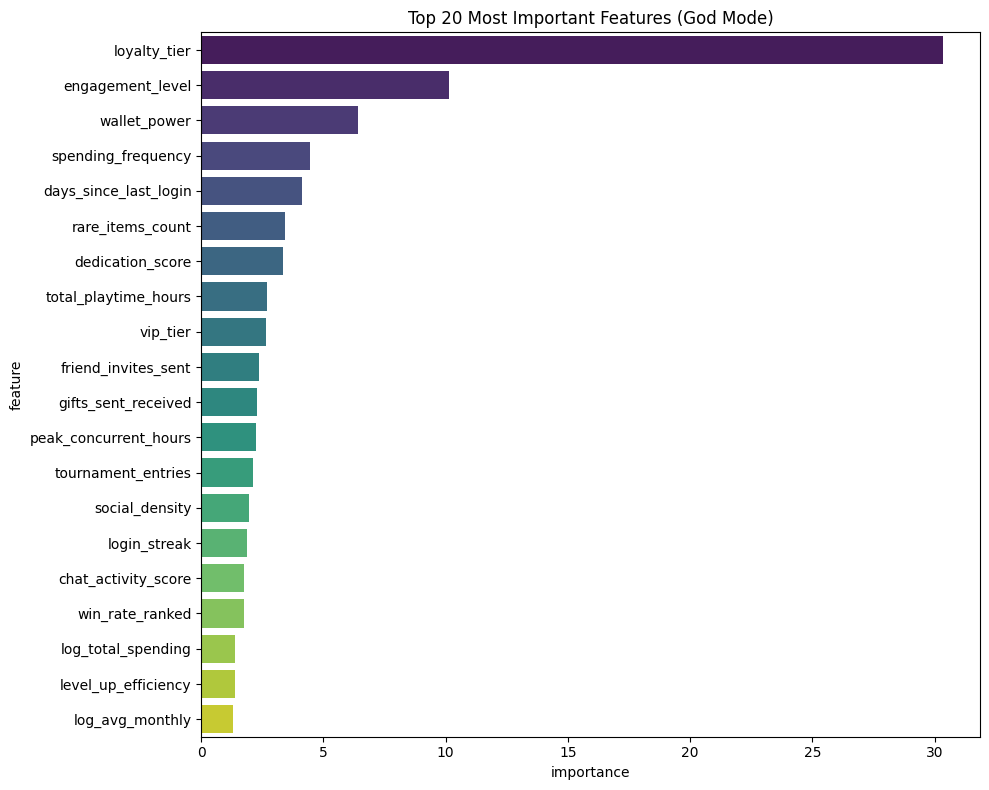

In [ ]:
!pip install catboost
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# ====================================================
# 1. DATA LOADING
# ====================================================
print("🔥 Initiating God Mode Pipeline...")
print("📦 Loading Data...")
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# เก็บ ID ไว้ส่ง
test_ids = test_df['id']

# ลบแถวที่ไม่มีเฉลย
train_df = train_df.dropna(subset=['segment']).reset_index(drop=True)
y = train_df['segment'].astype(int)

# รวมข้อมูลเพื่อทำ Feature Engineering ทีเดียว (Consistency)
train_len = len(train_df)
df_all = pd.concat([train_df.drop(columns=['segment']), test_df], axis=0).reset_index(drop=True)
df_all = df_all.drop(columns=['id', 'player_id'])

# ====================================================
# 2. EXTREME FEATURE ENGINEERING 🧪
# ====================================================
print("🛠️ Constructing Advanced Features...")

def extreme_fe(df):
    df = df.copy()

    # --- Group 1: Financial Power (จับ Whale) ---
    # Log Transform เงิน (เพราะพวก Whale จ่ายหนักเว่อร์ กราฟจะเบ้)
    df['log_total_spending'] = np.log1p(df['total_spending_thb'])
    df['log_avg_monthly'] = np.log1p(df['avg_monthly_spending'])

    # Spending Rate: จ่ายหนักแค่ไหนเทียบกับอายุไอดี
    df['spending_per_day'] = df['total_spending_thb'] / (df['account_age_days'] + 1)
    # Spending Efficiency: จ่ายคุ้มไหม (จ่ายเทียบกับเวลาเล่น)
    df['spending_per_hour'] = df['total_spending_thb'] / (df['total_playtime_hours'] + 1)
    # Wallet Depth: ศักยภาพเปย์ (VIP Tier * Monthly Spending)
    df['wallet_power'] = df['vip_tier'] * df['avg_monthly_spending']

    # --- Group 2: Grinding Intensity (จับ Grinder) ---
    # Dedication: ความทุ่มเท (เล่นนาน * ความถี่)
    df['dedication_score'] = df['avg_session_duration'] * df['play_frequency']
    # Hardcore Ratio: เล่น Rank เยอะแค่ไหนเทียบกับการเล่นทั้งหมด (สมมติ Rank คือส่วนหนึ่งของ total)
    # ถ้าไม่มี total matches ใช้ proxy อื่นแทน
    df['rank_intensity'] = df['ranked_participation_rate'] * df['win_rate_ranked']
    # Progression Speed: เวลไวแค่ไหน
    df['level_up_efficiency'] = df['speed_of_progression'] * df['achievement_completion_rate']

    # --- Group 3: Social Connectivity (จับ Social) ---
    # Social Network Density: เพื่อนเยอะ + เล่นทีมเยอะ
    df['social_density'] = df['friend_count'] * df['team_play_percentage']
    # Giver Index: สายเปย์เพื่อน (ส่งของขวัญ / จำนวนเพื่อน)
    df['generosity_ratio'] = df['gifts_sent_received'] / (df['friend_count'] + 1)
    # Chatty Score: คุยเก่งแค่ไหนเทียบกับเวลาเล่น
    df['chat_per_hour'] = df['chat_activity_score'] / (df['avg_session_duration'] + 1)

    # --- Group 4: Loyalty & Consistency ---
    # Loyalty Score: อยู่มานาน + ล็อกอินต่อเนื่อง
    df['loyalty_score'] = df['account_age_days'] * df['login_streak']
    # Dormancy Risk: ไม่ได้ล็อกอินนานแค่ไหนเทียบกับอายุไอดี
    df['dormancy_ratio'] = df['days_since_last_login'] / (df['account_age_days'] + 1)

    # --- Group 5: Preference Profiling ---
    # ชอบแต่งตัว vs ชอบเก่ง
    df['cosmetic_vs_performance'] = df['item_type_preference_cosmetic'] - df['item_type_preference_performance']

    return df

# ก่อนทำ FE เราต้อง Impute ค่า Numeric บางตัวก่อนเพื่อเอามาคํานวณ (เฉพาะตัวเลข)
# แต่ตัว Categorical ปล่อยไว้ให้ CatBoost จัดการ
num_cols = df_all.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='median')
df_all_filled_num = df_all.copy()
df_all_filled_num[num_cols] = imputer.fit_transform(df_all[num_cols])

# สร้าง Feature จากข้อมูลที่เติมค่าแล้ว (เพื่อความแม่นยำในการคำนวณ)
df_fe = extreme_fe(df_all_filled_num)

# เอา Feature ใหม่แปะกลับเข้าไปใน DataFrame หลัก (ที่มี Categorical แบบ Raw)
new_cols = [c for c in df_fe.columns if c not in df_all.columns]
df_all = pd.concat([df_all, df_fe[new_cols]], axis=1)

# ====================================================
# 3. PREPARING DATASETS
# ====================================================
# ระบุ Categorical Features ให้ชัดเจน
cat_features = [
    'region', 'platform', 'device_type', 'payment_method', 'language',
    'account_status', 'player_type_tag', 'engagement_level',
    'loyalty_tier', 'skill_tier', 'preferred_game_mode',
    'competitive_rank', 'vip_tier' # VIP Tier บางทีเป็น Cat ก็ดี
]

# แปลงให้เป็น String ให้หมด (CatBoost ต้องการ) & เติม Missing ด้วย 'Unknown'
for col in cat_features:
    if col in df_all.columns:
        df_all[col] = df_all[col].fillna('Unknown').astype(str)

# แยก Train/Test
X = df_all.iloc[:train_len]
X_test = df_all.iloc[train_len:]

print(f"🚀 Total Features: {X.shape[1]}")
print("   Ready for battle.")

# ====================================================
# 4. STRATIFIED K-FOLD TRAINING (The Grandmaster Way)
# ====================================================
# Params นี้จูนมาให้แบบเน้น Generalization (ไม่ Overfit แต่แม่น)
# ====================================================
# 4. TURBO TRAINING (Fast & Furious)
# ====================================================
cat_params = {
    'loss_function': 'MultiClass',
    'eval_metric': 'TotalF1',
    'iterations': 1000,             # ลดจาก 3000 -> 1000 (เร็วขึ้น 3 เท่า)
    'learning_rate': 0.1,           # เพิ่มจาก 0.02 -> 0.1 (เรียนรู้ไวขึ้น 5 เท่า)
    'depth': 6,                     # ลดความลึกเหลือ 6 (มาตรฐาน) คำนวณไวขึ้น
    'l2_leaf_reg': 3,
    'auto_class_weights': 'Balanced',
    'early_stopping_rounds': 50,    # หยุดไวขึ้นถ้าคะแนนไม่ขยับ
    'cat_features': [c for c in cat_features if c in X.columns],
    'verbose': 100,                 # โชว์ผลทุก 100 รอบพอ
    'random_seed': 42,
    'task_type': 'CPU',             # **ถ้าใช้ Colab/Kaggle ให้เปลี่ยนเป็น 'GPU' จะไวขึ้นอีก 10 เท่า!**
    'allow_writing_files': False
}

n_folds = 3  # ลดจาก 5 -> 3 Folds (เร็วขึ้นอีกเกือบเท่าตัว)
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

oof_preds = np.zeros((len(X), 4))     # เก็บผล Train ไว้ทำ Stacking (ถ้าจะทำ)
test_preds_prob = np.zeros((len(X_test), 4)) # เก็บผล Test เฉลี่ย

feature_importance_list = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n⚔️  FOLD {fold+1}/{n_folds} STARTED")

    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    train_pool = Pool(X_tr, y_tr, cat_features=[c for c in cat_features if c in X.columns])
    val_pool = Pool(X_val, y_val, cat_features=[c for c in cat_features if c in X.columns])

    model = CatBoostClassifier(**cat_params)
    model.fit(train_pool, eval_set=val_pool, use_best_model=True)

    # Predict Validation
    val_probs = model.predict_proba(val_pool)
    oof_preds[val_idx] = val_probs

    # Predict Test (สะสมไว้เฉลี่ย)
    test_preds_prob += model.predict_proba(X_test) / n_folds

    # Score
    val_preds_cls = np.argmax(val_probs, axis=1)
    f1 = f1_score(y_val, val_preds_cls, average='macro')
    print(f"✅ Fold {fold+1} F1-Macro: {f1:.4f}")

    feature_importance_list.append(model.get_feature_importance())

# ====================================================
# 5. EVALUATION & SUBMISSION
# ====================================================
print("\n🏆 FINAL RESULTS")
oof_cls = np.argmax(oof_preds, axis=1)
total_f1 = f1_score(y, oof_cls, average='macro')
print(f"🔥 Overall CV F1-Macro: {total_f1:.5f}")
print("\nClassification Report (OOF):")
print(classification_report(y, oof_cls))

# สร้าง Feature Importance Plot (ดูว่าตัวไหนแบกทีม)
feature_importance = np.mean(feature_importance_list, axis=0)
fi_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance})
fi_df = fi_df.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=fi_df, palette='viridis')
plt.title('Top 20 Most Important Features (God Mode)')
plt.tight_layout()
plt.savefig('feature_importance_task2.png')
print("📊 Feature Importance plot saved.")

# สร้างไฟล์ส่ง
final_predictions = np.argmax(test_preds_prob, axis=1)
submission = pd.DataFrame({
    'id': test_ids,
    'segment': final_predictions
})

# Check Distribution (ควรจะสมดุล ไม่ใช่ตอบ 0 หมด)
print("\nPrediction Distribution:")
print(submission['segment'].value_counts(normalize=True).sort_index())

submission.to_csv('submission_task2_god_mode.csv', index=False)
print("\n✅ Mission Complete. Submission saved as 'submission_task2_god_mode.csv'")